In [38]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cartopy.crs as ccrs
from pyresample import geometry, grid
import pyresample
import matplotlib.pyplot as plt
import datetime
import metpy
import datetime
import xarray as xr
from pyresample import geometry, grid
import cartopy.crs as ccrs
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import math
from skimage.transform import resize
from skimage.transform import resize_local_mean
import tensorflow as tf
import tensorflow_hub as hub
from skimage.filters import laplace
from skimage.filters import unsharp_mask
import math
from PIL import Image
import scipy.stats

model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
random.seed(42)

from sharpening_functions import *
from cropping_functions import *
from plotting_functions import *

In [2]:
pc = ccrs.PlateCarree()
pc_params = pc.proj4_params
shape = [500, 500]
pc_extents = [-124.25, 32.25, -114.25, 42.25]
target_area = geometry.AreaDefinition.from_extent('CA', pc_params, shape, pc_extents)

In [3]:
goes_path = '../landsat_files/'
landsat_path = '../landsat_files/landsat_files/'

day1 = {'goes':'2021240', 'landsat':'20210828'}
day2 = {'goes':'2021247', 'landsat':'20210904'}

a1 = {'day':day1, 'loc':'A', 'lat_0':40.49, 'lon_0':-121.45, 'lat_f':40.650000000000006, 'lon_f':-121.17}
b1 = {'day':day1, 'loc':'B', 'lat_0':39.91, 'lon_0':-120.97, 'lat_f':40.13, 'lon_f':-120.49000000000001}
a2 = {'day':day2, 'loc':'A', 'lat_0':40.707499999999996, 'lon_0':-123.4325, 'lat_f':41.1325, 'lon_f':-122.7075}
b2 = {'day':day2, 'loc':'B', 'lat_0':41.027499999999996, 'lon_0':-123.0925, 'lat_f':41.31250000000001, 'lon_f':-122.6875}


subsets = [a1, b1, a2, b2]

# for subset in subsets:
#     name = 'goes' + subset['day']['goes'] + subset['loc']
#     np.save("Landsat Subsets/" + name + '039.npy', subset['original_goes_img_039'])
#     np.save("Landsat Subsets/" + name + '103.npy', subset['original_goes_img_103'])

In [5]:
def latslons(subset):
    coords_0 = target_area.get_array_coordinates_from_lonlat(subset['lon_0'], subset['lat_0'])
    coords_0 = (round(coords_0[0]), round(coords_0[1]))
    coords_f = target_area.get_array_coordinates_from_lonlat(subset['lon_f'], subset['lat_f'])
    coords_f = (round(coords_f[0]), round(coords_f[1]))
    subset['lons'] = [coords_0[0], coords_f[0]]
    subset['lats'] = [coords_f[1], coords_0[1]]

In [6]:
def pixshifts(subset):
    for file in os.listdir(landsat_path):
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'red_grid' + subset['loc'] + 'cent0.02deg.npy':
            refimg = np.flipud(np.load(landsat_path + file))

    for file in os.listdir(goes_path):
        if file[:34] == 'OR_ABI-L1b-RadC-M6C02_G17_s' + subset['day']['goes']:
            newimg_full = np.load(goes_path + file)
    
    lats = subset['lats']
    lons = subset['lons']

    newimg = newimg_full[lats[0]:lats[1], lons[0]:lons[1]]
    
    x_add = 0
    y_add = 0
    
    while refimg.shape != newimg.shape: 
        if refimg.shape[0] > newimg.shape[0]:
            x_add += 1
        elif refimg.shape[0] < newimg.shape[0]:
            x_add -= 1
        if refimg.shape[1] > newimg.shape[1]:
            y_add += 1
        elif refimg.shape[1] < newimg.shape[1]:
            y_add -= 1
        
        newimg = newimg_full[lats[0]:lats[1] + x_add, lons[0]:lons[1] + y_add]
    
    lats[1] += x_add
    lons[1] += y_add

    nx = 1
    ny = 1
    x_shift = np.arange(-nx, nx+1)
    y_shift = np.arange(-ny, ny+1)
    scores = []
    
    for x in x_shift:
        for y in y_shift:
            testimg = newimg_full[lats[0]+x:lats[1]+x, lons[0]+y:lons[1]+y]
            scores.append([x, y, np.corrcoef(refimg.flatten(), testimg.flatten())[0, 1]])
    
    max_score = 0
    min_score_index = 0
    
    for score_index in range(len(scores)-1):
        score = scores[score_index][-1]
        if abs(score) > abs(max_score):
            max_score = score
            max_score_index = score_index
            
    min_x, min_y, max_score = scores[max_score_index]
    subset['shift'] = [min_x, min_y]

In [165]:
def results(refimg, newimg, title):
    corrcoef, p = scipy.stats.pearsonr(refimg.flatten(), newimg.flatten())
    rmse = math.sqrt(np.square(refimg - newimg).mean())
    
    print(title + " correlation coefficient: " + str(corrcoef))
    print(title + " rmse: " + str(rmse))
    return [corrcoef, rmse]

In [192]:
titles = ['ESRGAN', 'Laplace', 'Unsharp Mask', 'Control']

for subset in subsets:
    latslons(subset)
    pixshifts(subset)
    applySR(subset)
    
    corrcoeffs = []
    rmses = []

    print('Subset ' + subset['loc'])
    stats = [subset['esrgan_goes_diff'], subset['laplace_goes_diff'], subset['unsharpmask_goes_diff'], subset['control_goes_diff']]
    for n in range(len(titles)):
        vals = results(subset['landsat_diff'], stats[n], titles[n])
        corrcoeffs.append(vals[0])
        rmses.append(vals[1])
        
    subset['corrcoeffs_diff'] = corrcoeffs
    subset['rmses_diff'] = rmses

    print('')

Subset A
ESRGAN correlation coefficient: 0.25717075216929763
ESRGAN rmse: 7.206610162471603
Laplace correlation coefficient: 0.29893155369167695
Laplace rmse: 7.765280642703686
Unsharp Mask correlation coefficient: 0.2800493740293436
Unsharp Mask rmse: 7.46327621965964
Control correlation coefficient: 0.27918190466167525
Control rmse: 7.286483078857113

Subset B
ESRGAN correlation coefficient: 0.34589828453210614
ESRGAN rmse: 9.667757520716046
Laplace correlation coefficient: 0.30379751451440545
Laplace rmse: 9.963987137503894
Unsharp Mask correlation coefficient: 0.32383958732823787
Unsharp Mask rmse: 9.568875192407255
Control correlation coefficient: 0.33146229697392426
Control rmse: 9.170497524860783

Subset A
ESRGAN correlation coefficient: 0.15065927120044917
ESRGAN rmse: 5.083494650763324
Laplace correlation coefficient: 0.16494436613582728
Laplace rmse: 5.623483705052207
Unsharp Mask correlation coefficient: 0.17865171576030128
Unsharp Mask rmse: 5.276403834678157
Control correl

In [191]:
print('10.3 micron stats \n')

titles = ['ESRGAN', 'Laplace', 'Unsharp Mask', 'Control']

for subset in subsets:
    latslons(subset)
    pixshifts(subset)
    applySR(subset)    
    
    corrcoeffs = []
    rmses = []

    print('Subset ' + subset['loc'])
    stats = [subset['esrgan_goes_img_103'], subset['laplace_goes_img_103'], subset['unsharpmask_goes_img_103'], subset['control_goes_img_103']]
    for n in range(len(titles)):
        vals = results(subset['landsat_img_103'], stats[n], titles[n])
        corrcoeffs.append(vals[0])
        rmses.append(vals[1])
        
    subset['corrcoeffs_103'] = corrcoeffs
    subset['rmses_103'] = rmses

    print('')

10.3 micron stats 

Subset A
ESRGAN correlation coefficient: 0.7368732819653417
ESRGAN rmse: 7.043065790256646
Laplace correlation coefficient: 0.7269331111640916
Laplace rmse: 6.643183313797238
Unsharp Mask correlation coefficient: 0.7481562455429597
Unsharp Mask rmse: 6.619107319126691
Control correlation coefficient: 0.7557057144566074
Control rmse: 6.610742378639031

Subset B
ESRGAN correlation coefficient: 0.8172538761141256
ESRGAN rmse: 6.5145313947576176
Laplace correlation coefficient: 0.8152935804584674
Laplace rmse: 6.050080517779194
Unsharp Mask correlation coefficient: 0.8298802150664158
Unsharp Mask rmse: 6.043350077487818
Control correlation coefficient: 0.8330123434087041
Control rmse: 6.060764180517319

Subset A
ESRGAN correlation coefficient: 0.5257092507358369
ESRGAN rmse: 4.788669203523382
Laplace correlation coefficient: 0.46430506311971753
Laplace rmse: 4.553278335567365
Unsharp Mask correlation coefficient: 0.5006731096939097
Unsharp Mask rmse: 4.48268286105872
Co

In [193]:
print('3.9 micron stats \n')

titles = ['ESRGAN', 'Laplace', 'Unsharp Mask', 'Control']

for subset in subsets:
    latslons(subset)
    pixshifts(subset)
    applySR(subset)    
    
    corrcoeffs = []
    rmses = []

    print('Subset ' + subset['loc'])
    stats = [subset['esrgan_goes_img_039'], subset['laplace_goes_img_039'], subset['unsharpmask_goes_img_039'], subset['control_goes_img_039']]
    for n in range(len(titles)):
        vals = results(subset['landsat_img_039'], stats[n], titles[n])
        corrcoeffs.append(vals[0])
        rmses.append(vals[1])
        
    subset['corrcoeffs_039'] = corrcoeffs
    subset['rmses_039'] = rmses

    print('')

3.9 micron stats 

Subset A
ESRGAN correlation coefficient: 0.5278065784477275
ESRGAN rmse: 4.411819304087561
Laplace correlation coefficient: 0.5194947275069708
Laplace rmse: 5.219429433033676
Unsharp Mask correlation coefficient: 0.5331981691905175
Unsharp Mask rmse: 4.759613844114786
Control correlation coefficient: 0.5429107200417571
Control rmse: 4.454405051175949

Subset B
ESRGAN correlation coefficient: 0.20748138928500248
ESRGAN rmse: 8.644922567880775
Laplace correlation coefficient: 0.21631500221224362
Laplace rmse: 9.031697479857643
Unsharp Mask correlation coefficient: 0.2212074237491014
Unsharp Mask rmse: 8.53447193289298
Control correlation coefficient: 0.22050326992232247
Control rmse: 8.060585556697738

Subset A
ESRGAN correlation coefficient: 0.2923211851054791
ESRGAN rmse: 4.494215226070471
Laplace correlation coefficient: 0.2881347462162106
Laplace rmse: 5.13682043920555
Unsharp Mask correlation coefficient: 0.3164083567955773
Unsharp Mask rmse: 4.6376689312629615
Co

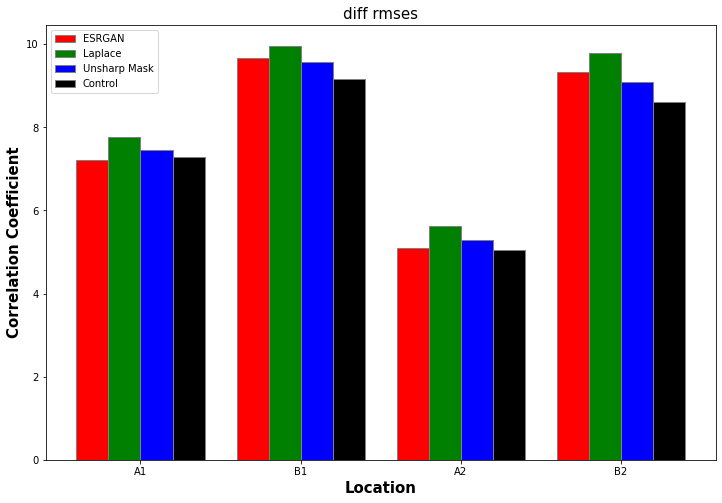

In [245]:
wavelength = 'diff'
stat = 'rmses'

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

A1 = subsets[0][stat + '_' + wavelength]
B1 = subsets[1][stat + '_' + wavelength]
A2 = subsets[2][stat + '_' + wavelength]
B2 = subsets[3][stat + '_' + wavelength]
data = A1 + B1 + A2 + B2

esrgan = data[0::4]
laplace = data[1::4]
unsharpmask = data[2::4]
control = data[3::4]
 
br1 = 1.25*np.arange(len(A1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
 
plt.bar(br1, esrgan, color ='r', width = barWidth,
        edgecolor ='grey', label ='ESRGAN')
plt.bar(br2, laplace, color ='g', width = barWidth,
        edgecolor ='grey', label ='Laplace')
plt.bar(br3, unsharpmask, color ='b', width = barWidth,
        edgecolor ='grey', label ='Unsharp Mask')
plt.bar(br4, control, color ='black', width = barWidth,
        edgecolor ='grey', label ='Control')
 
plt.title(wavelength + ' ' + stat, fontsize = 15)
plt.xlabel('Location', fontweight ='bold', fontsize = 15)
plt.ylabel('Correlation Coefficient', fontweight ='bold', fontsize = 15)
plt.xticks([1.25*r + 1.5*barWidth for r in range(len(A1))],
        ['A1', 'B1', 'A2', 'B2'])
 
plt.legend()
plt.show()

In [226]:
for subset in subsets:
    for wavelength in '039', '103':
        x = subset['landsat_img_' + wavelength]
        y = subset['control_goes_img_' + wavelength]
        
        x_20, x_80 = np.quantile(x, [0.2, 0.8])
        y_20, y_80 = np.quantile(y, [0.2, 0.8])
        
        m = (y_80 - y_20)/(x_80 - x_20)
        b = y_20 - m*x_20
    
        subset['landsat_correction_' + wavelength] = [m, b]

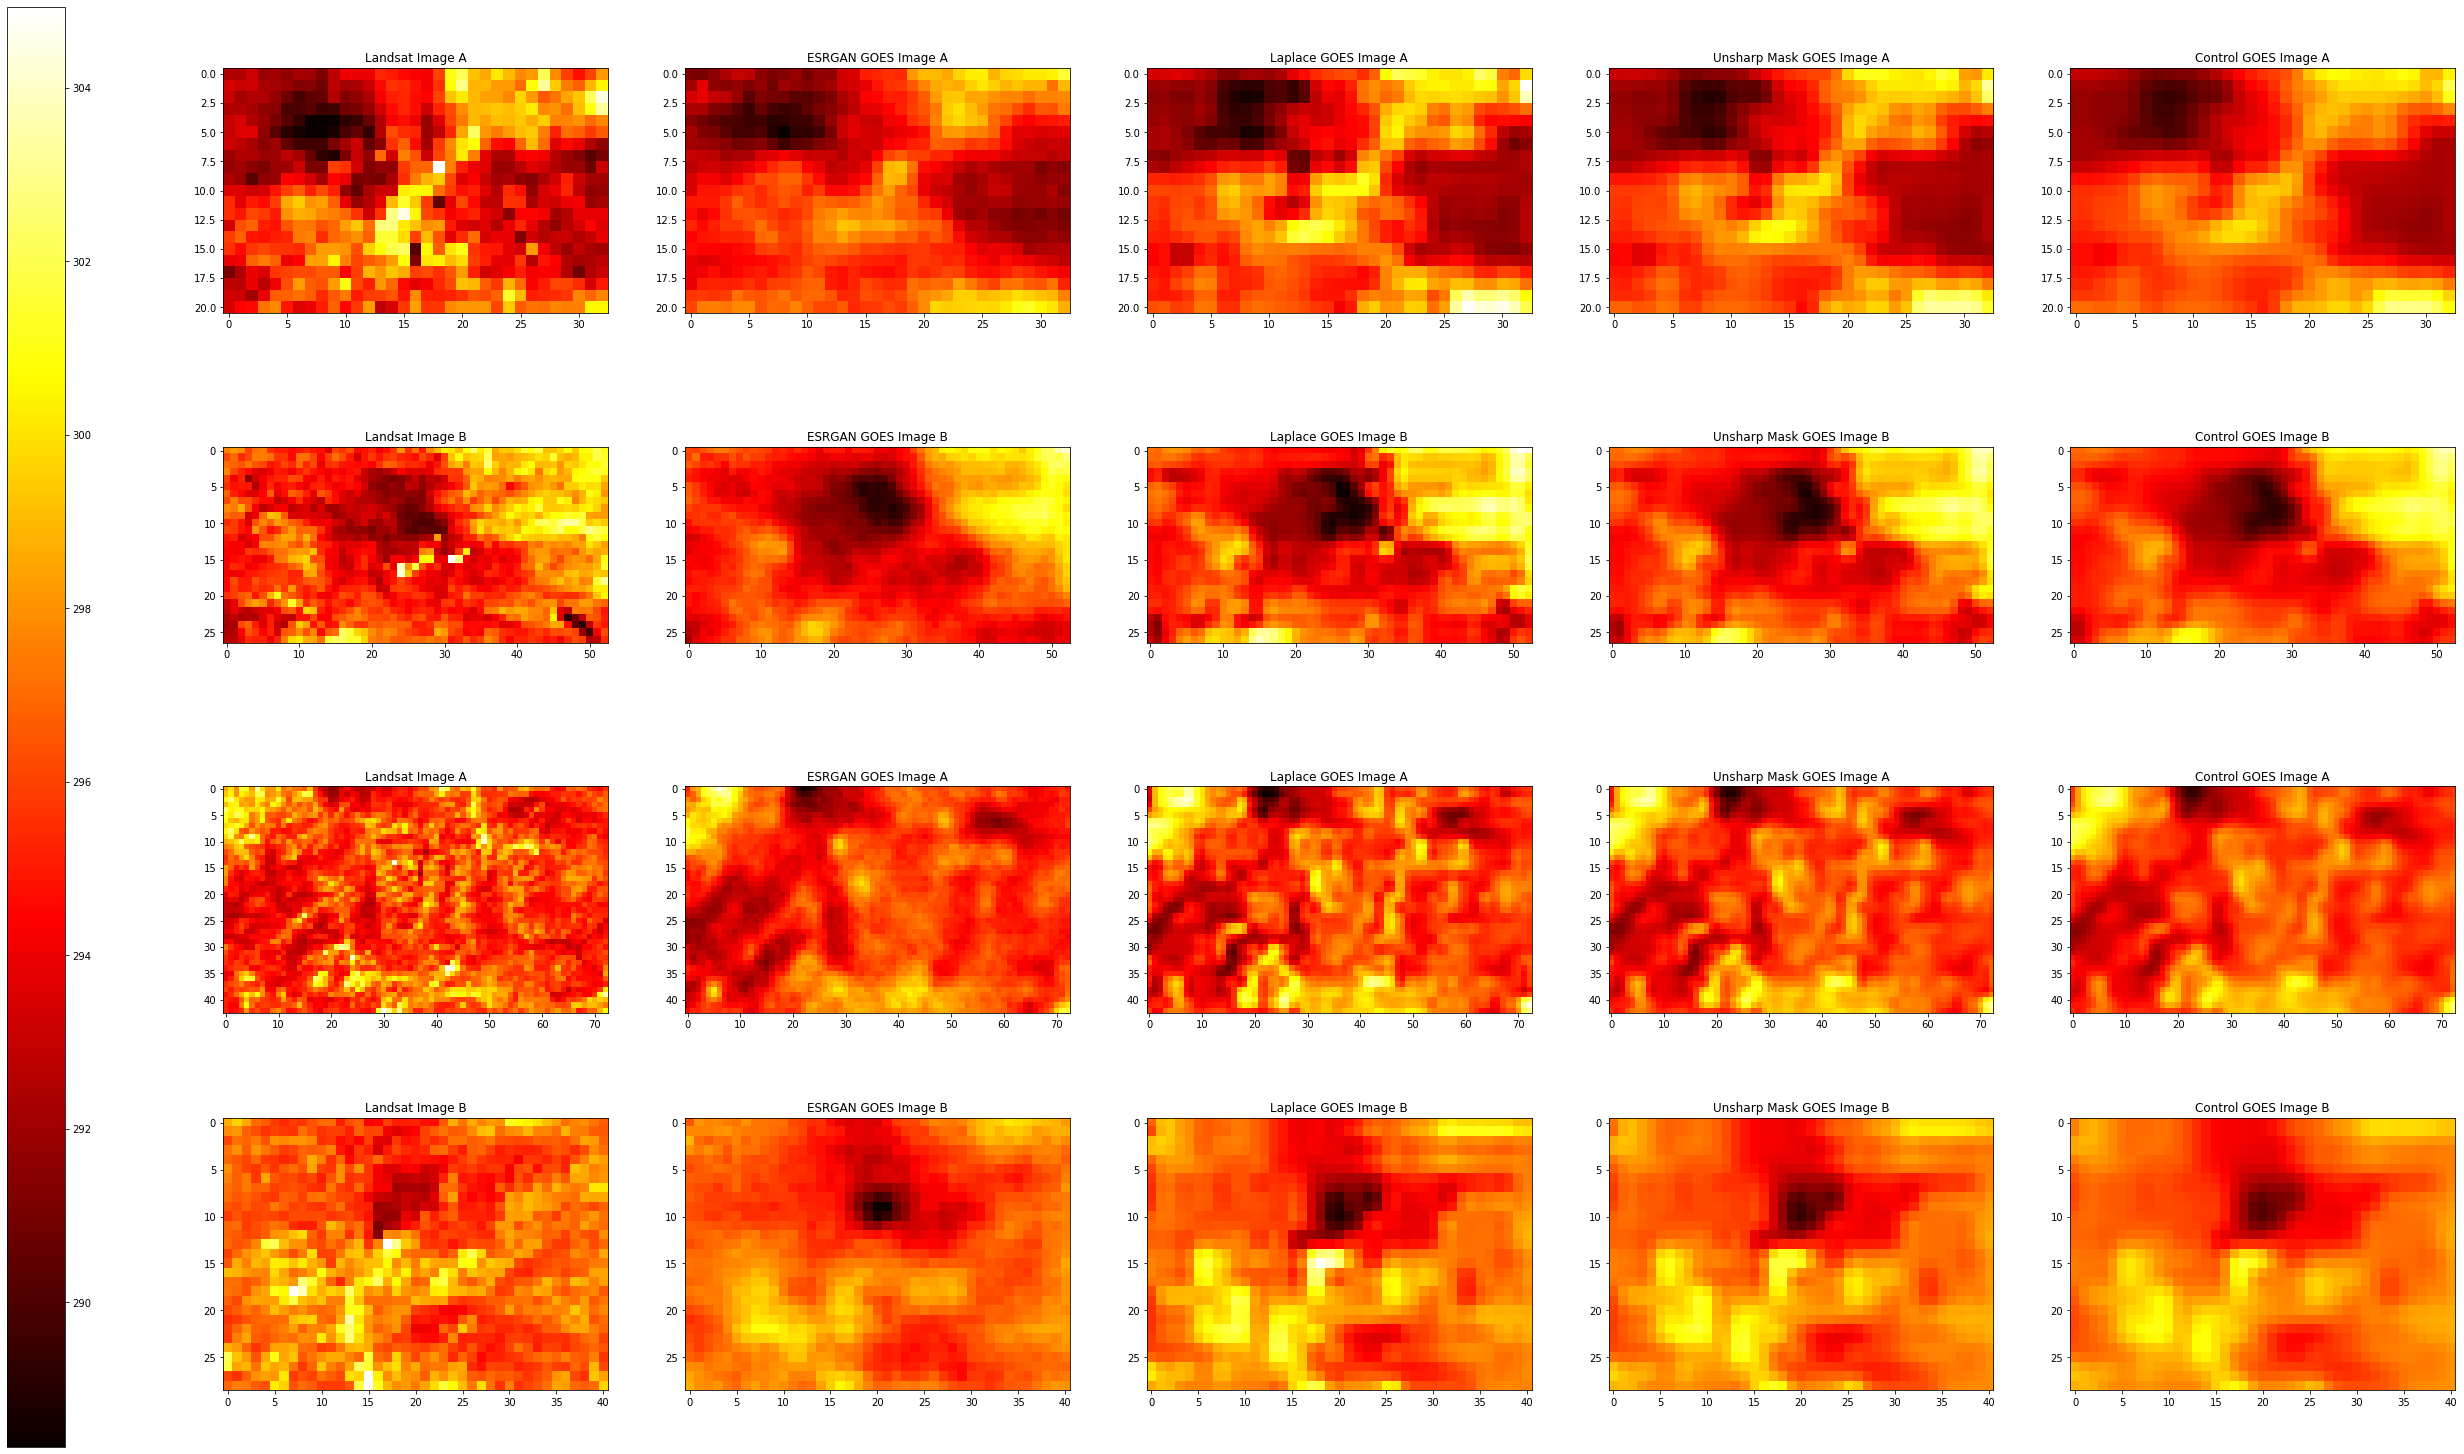

In [232]:
wavelength = '103'

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 5, figsize=(40, 25))
axs = [ax1, ax2, ax3, ax4]

for n in range(4):
    ax = axs[n]
    subset = subsets[n]
    
    vals = np.vstack([subset['esrgan_goes_img_' + wavelength].ravel(), subset['laplace_goes_img_' + wavelength].ravel(), 
                      subset['unsharpmask_goes_img_' + wavelength].ravel(), subset['control_goes_img_' + wavelength].ravel()])
    max_temp = vals.max()
    min_temp = vals.min()
    
    im = ax[0].imshow(subset['landsat_img_' + wavelength]*subset['landsat_correction_' + wavelength][0] + subset['landsat_correction_' + wavelength][1], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[0].set_title('Landsat Image ' + subset['loc'])
    ax[1].imshow(subset['esrgan_goes_img_' + wavelength], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[1].set_title('ESRGAN GOES Image ' + subset['loc'])
    ax[2].imshow(subset['laplace_goes_img_' + wavelength], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[2].set_title('Laplace GOES Image ' + subset['loc'])
    ax[3].imshow(subset['unsharpmask_goes_img_' + wavelength], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[3].set_title('Unsharp Mask GOES Image ' + subset['loc'])
    ax[4].imshow(subset['control_goes_img_' + wavelength], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[4].set_title('Control GOES Image ' + subset['loc'])
    
cb_ax = f.add_axes([0.05, 0.1, 0.02, 0.8])
cbar = f.colorbar(im, cax=cb_ax)

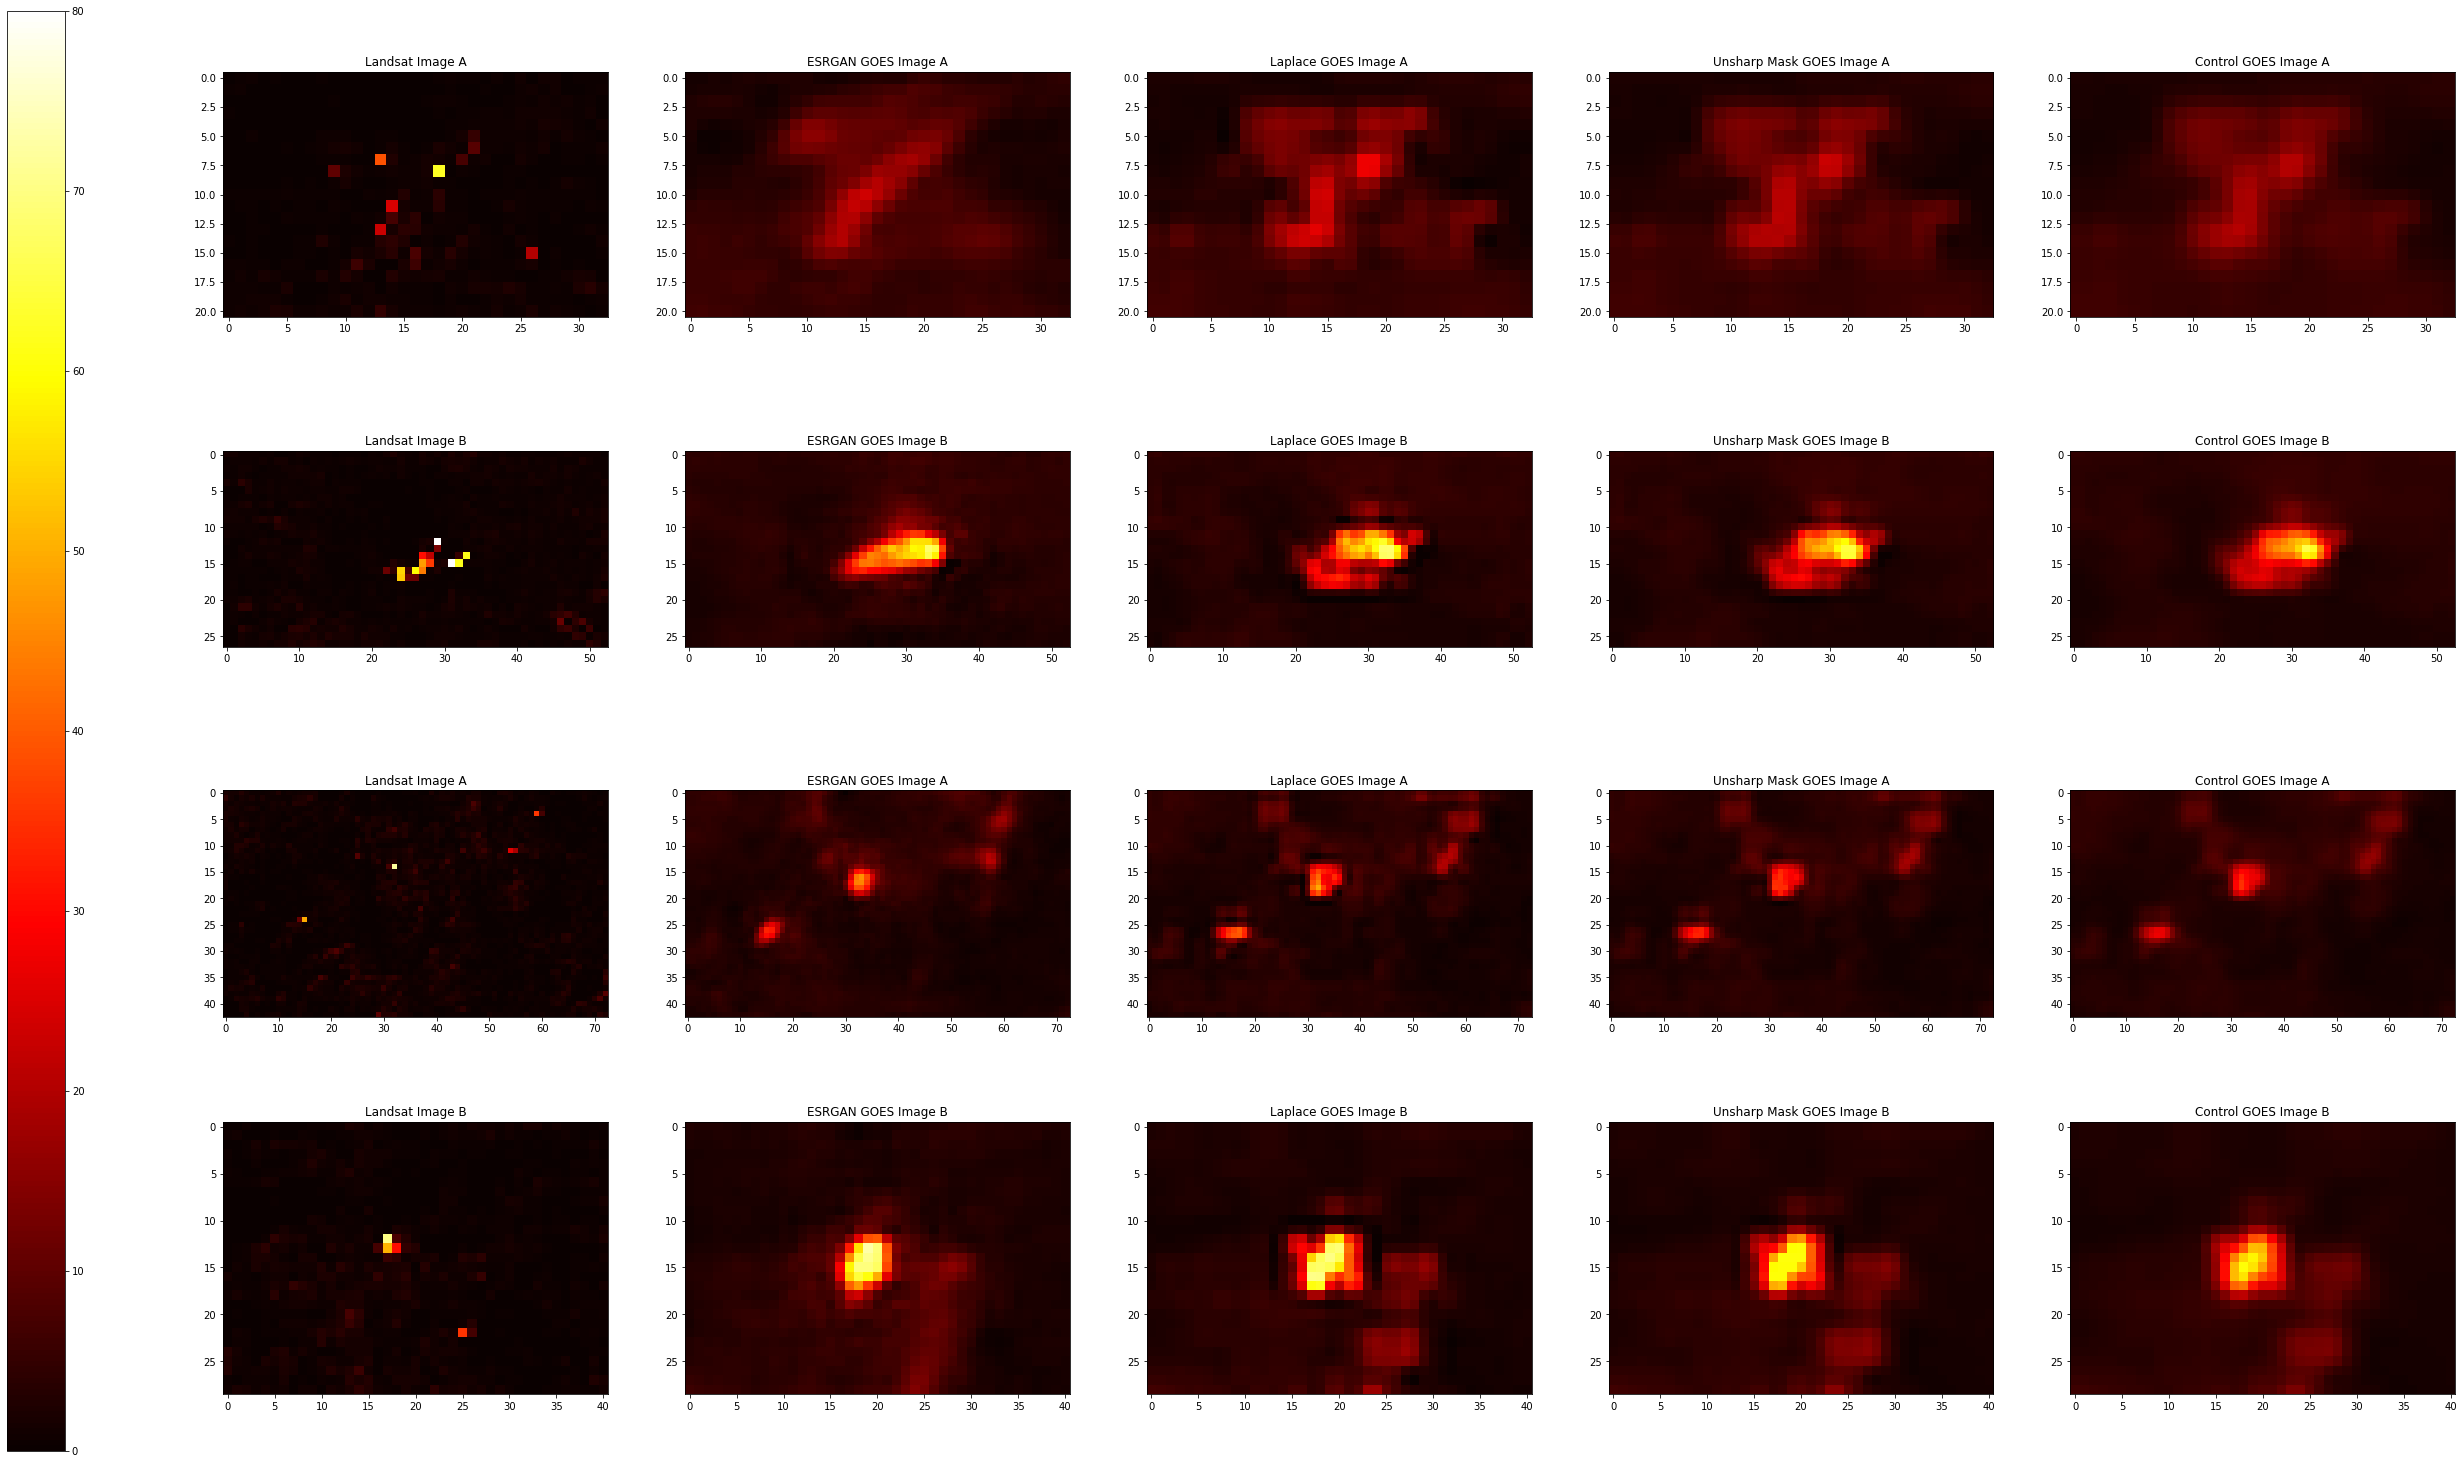

In [242]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 5, figsize=(40, 25))
axs = [ax1, ax2, ax3, ax4]

max_temp = 80
min_temp = 0

for n in range(4):
    ax = axs[n]
    subset = subsets[n]
    
    im = ax[0].imshow(10*subset['landsat_diff'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[0].set_title('Landsat Image ' + subset['loc'])
    ax[1].imshow(subset['esrgan_goes_diff'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[1].set_title('ESRGAN GOES Image ' + subset['loc'])
    ax[2].imshow(subset['laplace_goes_diff'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[2].set_title('Laplace GOES Image ' + subset['loc'])
    ax[3].imshow(subset['unsharpmask_goes_diff'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[3].set_title('Unsharp Mask GOES Image ' + subset['loc'])
    ax[4].imshow(subset['control_goes_diff'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[4].set_title('Control GOES Image ' + subset['loc'])
    
cb_ax = f.add_axes([0.05, 0.1, 0.02, 0.8])
cbar = f.colorbar(im, cax=cb_ax)

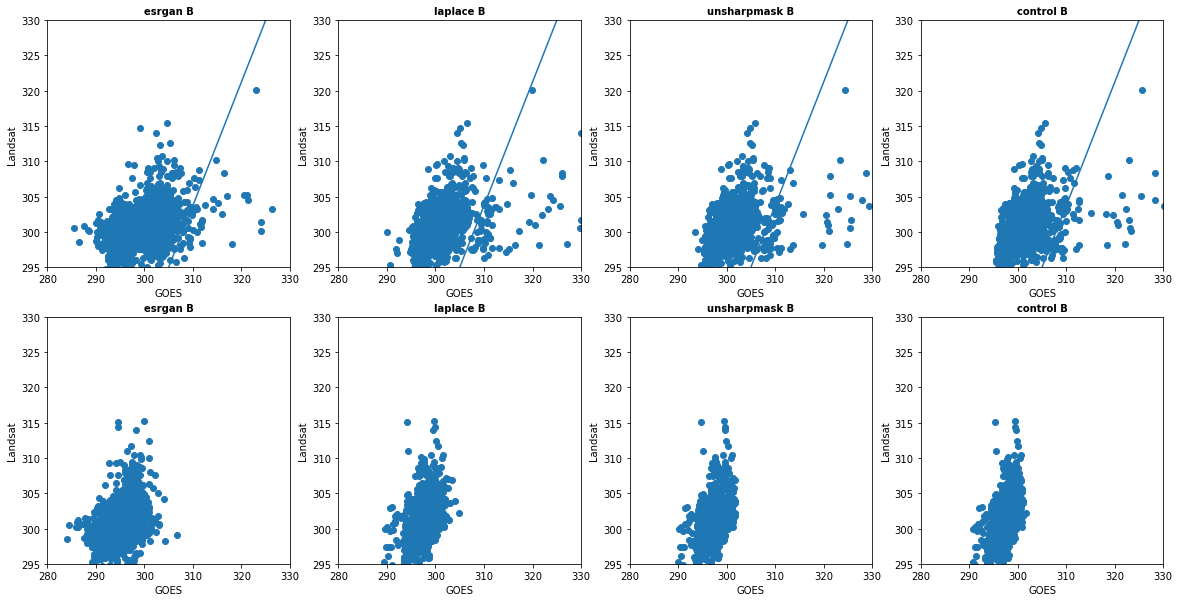

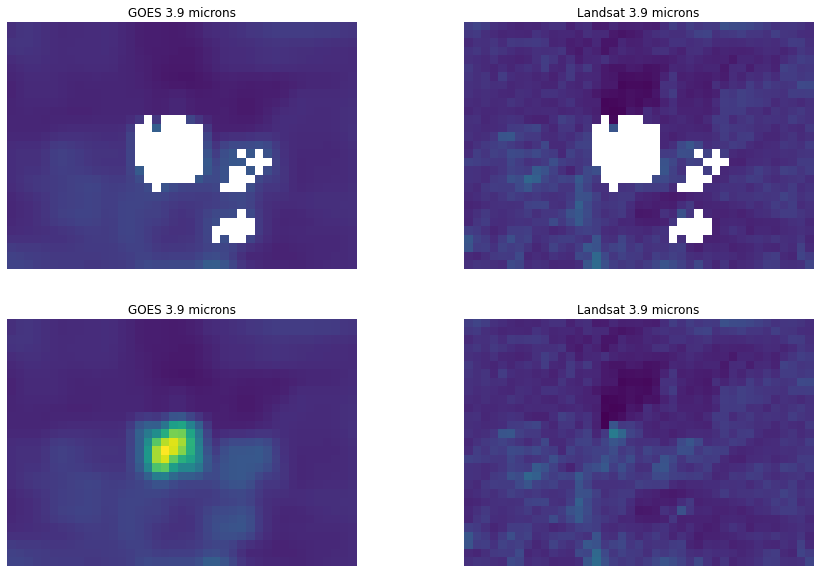

In [21]:
x_coords = [305, 325]
y_coords = [295, 330]

ax1, ax2 = plot_all_pts(subsets[n])
for n in range(4):
    ax1[n].plot(x_coords, y_coords)

plot_outer_pts(x_coords, y_coords, subsets[n])

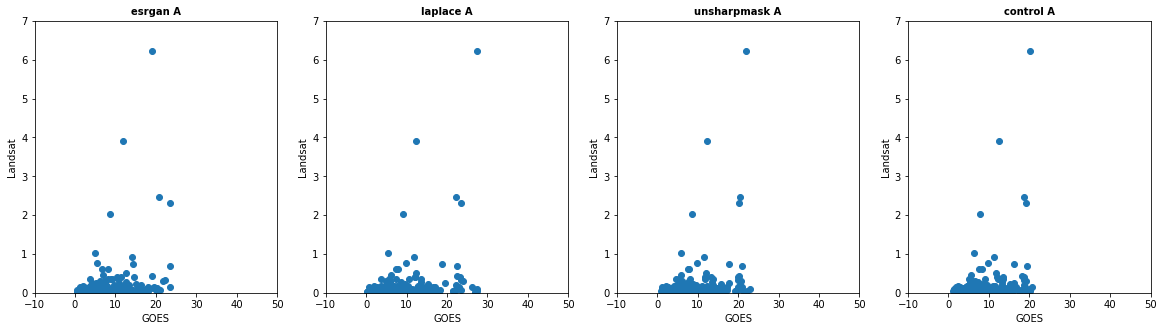

In [22]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))

fontsize = 10
    
subset = subsets[0]
    
ax[0].scatter(subset['esrgan_goes_diff'], subset['landsat_diff'])
ax[0].set_title('esrgan ' + subset['loc'], fontsize = fontsize, fontweight ='bold')

ax[1].scatter(subset['laplace_goes_diff'], subset['landsat_diff'])
ax[1].set_title('laplace ' + subset['loc'], fontsize = fontsize, fontweight ='bold')

ax[2].scatter(subset['unsharpmask_goes_diff'], subset['landsat_diff'])
ax[2].set_title('unsharpmask ' + subset['loc'], fontsize = fontsize, fontweight ='bold')

ax[3].scatter(subset['control_goes_diff'], subset['landsat_diff'])
ax[3].set_title('control ' + subset['loc'], fontsize = fontsize, fontweight ='bold')

for n in range(4):
    ax[n].set_xlabel('GOES', fontsize = fontsize)
    ax[n].set_ylabel('Landsat', fontsize = fontsize)
    ax[n].set_xlim(-10, 50)
    ax[n].set_ylim(0, 7)

In [9]:
def applySR(subset):
    for file in os.listdir(landsat_path):
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'BT3.9_grid' + subset['loc'] + 'cent0.02deg.npy':
            landsat_img_039 = np.flipud(np.load(landsat_path + file))
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'BT10.3_grid' + subset['loc'] + 'cent0.02deg.npy':
            landsat_img_103 = np.flipud(np.load(landsat_path + file))
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'BT3.9_grid' + subset['loc'] + 'cent0.01deg.npy':
            new_landsat_img_039 = np.flipud(np.load(landsat_path + file))
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'BT10.3_grid' + subset['loc'] + 'cent0.01deg.npy':
            new_landsat_img_103 = np.flipud(np.load(landsat_path + file))

    for file in os.listdir(goes_path):
        if file[:34] == 'OR_ABI-L1b-RadC-M6C07_G17_s' + subset['day']['goes']:
            goes_img_039 = np.load(goes_path + file)
        if file[:34] == 'OR_ABI-L1b-RadC-M6C14_G17_s' + subset['day']['goes']:
            goes_img_103 = np.load(goes_path + file)
            
    new_landsat_diff = new_landsat_img_039 - new_landsat_img_103
    subset['landsat_diff'] = new_landsat_diff
    subset['landsat_img_039'] = new_landsat_img_039
    subset['landsat_img_103'] = new_landsat_img_103

    goes_img_expanded_039 = expand(landsat_img_039, goes_img_039, subset['shift'][0], subset['shift'][1], subset['lats'], subset['lons'])
    goes_img_expanded_103 = expand(landsat_img_103, goes_img_103, subset['shift'][0], subset['shift'][1], subset['lats'], subset['lons'])
    
    subset['original_goes_img_039'] = shiftPixels(landsat_img_039, goes_img_expanded_039, subset['shift'][0], subset['shift'][1])
    subset['original_goes_img_103'] = shiftPixels(landsat_img_103, goes_img_expanded_103, subset['shift'][0], subset['shift'][1])
    subset['original_landsat_img_039'] = landsat_img_039
    subset['original_landsat_img_103'] = landsat_img_103

    esrgan_goes_img_039 = shiftPixels(new_landsat_img_039, esrgan_sharpening_img(goes_img_expanded_039), subset['shift'][0], subset['shift'][1])
    esrgan_goes_img_103 = shiftPixels(new_landsat_img_103, esrgan_sharpening_img(goes_img_expanded_103), subset['shift'][0], subset['shift'][1])
    esrgan_goes_img_039[esrgan_goes_img_039 > 373] = 373
    esrgan_goes_img_103[esrgan_goes_img_103 > 373] = 373
    subset['esrgan_goes_diff'] = esrgan_goes_img_039 - esrgan_goes_img_103
    subset['esrgan_goes_img_039'] = esrgan_goes_img_039
    subset['esrgan_goes_img_103'] = esrgan_goes_img_103

    laplace_goes_img_039 = shiftPixels(new_landsat_img_039, laplace_sharpening_img(goes_img_expanded_039), subset['shift'][0], subset['shift'][1])
    laplace_goes_img_103 = shiftPixels(new_landsat_img_103, laplace_sharpening_img(goes_img_expanded_103), subset['shift'][0], subset['shift'][1])
    laplace_goes_img_039[laplace_goes_img_039 > 373] = 373
    laplace_goes_img_103[laplace_goes_img_103 > 373] = 373
    subset['laplace_goes_diff'] = laplace_goes_img_039 - laplace_goes_img_103
    subset['laplace_goes_img_039'] = laplace_goes_img_039
    subset['laplace_goes_img_103'] = laplace_goes_img_103

    unsharpmask_goes_img_039 = shiftPixels(new_landsat_img_039, unsharpmask_sharpening_img(goes_img_expanded_039), subset['shift'][0], subset['shift'][1])
    unsharpmask_goes_img_103 = shiftPixels(new_landsat_img_103, unsharpmask_sharpening_img(goes_img_expanded_103), subset['shift'][0], subset['shift'][1])
    unsharpmask_goes_img_039[unsharpmask_goes_img_039 > 373] = 373
    unsharpmask_goes_img_103[unsharpmask_goes_img_103 > 373] = 373
    subset['unsharpmask_goes_diff'] = unsharpmask_goes_img_039 - unsharpmask_goes_img_103
    subset['unsharpmask_goes_img_039'] = unsharpmask_goes_img_039
    subset['unsharpmask_goes_img_103'] = unsharpmask_goes_img_103

    control_goes_img_039 = shiftPixels(new_landsat_img_039, control_img(goes_img_expanded_039), subset['shift'][0], subset['shift'][1])
    control_goes_img_103 = shiftPixels(new_landsat_img_103, control_img(goes_img_expanded_103), subset['shift'][0], subset['shift'][1])
    control_goes_img_039[control_goes_img_039 > 373] = 373
    control_goes_img_103[control_goes_img_103 > 373] = 373
    subset['control_goes_diff'] = control_goes_img_039 - control_goes_img_103
    subset['control_goes_img_039'] = control_goes_img_039
    subset['control_goes_img_103'] = control_goes_img_103